In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision

from tqdm import tqdm
from matplotlib import pyplot as plt

from networks.cnn import CNN
from attacks.fgsm import FGSMTransform, ToTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

%load_ext autoreload
%autoreload 2

BASE_MODEL_PATH = "./models/cnn.pth" 
base_model = CNN().to(device)
base_model.load_state_dict(torch.load(BASE_MODEL_PATH))
EPOCHS = 10
EPSILONS =  [0.005, 0.01, 0.015, 0.2]

Device: cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


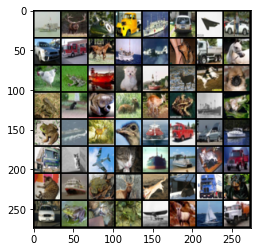

Loss: 0.6354, Accuracy: 0.8043


(0.63539064, 0.8043392)

In [18]:
def imshow(img):
    npimg = torchvision.utils.make_grid(img).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
t = transforms.Compose([ToTensor(),FGSMTransform(epsilon=0)])
tdata=CustomCIFAR(root="./data", train=False, transform=t)
tloader = torch.utils.data.DataLoader(tdata, batch_size=64, shuffle=True)
for i, j in tloader:
    imshow(i)
    break
criterion = torch.nn.CrossEntropyLoss()

simple_test(tloader, criterion, base_model)


In [2]:
#training a model with batchsize=1 on original images to fix dimension errors in the transform of fgsm
transform = transforms.Compose([transforms.ToTensor()])
train_dataset1 = datasets.CIFAR10(root='./data', train=True, transform=transform)
train_loader_bs1 = torch.utils.data.DataLoader(dataset=train_dataset1, batch_size=1, shuffle=True)

model_batchsize1 = CNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_batchsize1.parameters(), lr=0.001)
EPOCHS = 10
# Train the model
progress = tqdm(total=len(train_loader_bs1)*EPOCHS, desc="Training") # add a progress bar
for epoch in range(EPOCHS):
    for images, labels in train_loader_bs1:
        model_batchsize1.train()
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_batchsize1(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress.update(1)
    
    progress.write(f'Epoch [{epoch+1}/{10}], Loss: {loss.item():.4f}')

# #saving model
torch.save(model_batchsize1.state_dict(), "./models/cnn_batchsize1.pth")
print("Saved PyTorch Model State as cnn_batchsize1.pth")

Training:  10%|█         | 50033/500000 [04:35<39:07, 191.64it/s]  

Epoch [1/10], Loss: 0.1867


Training:  20%|██        | 100036/500000 [08:55<35:38, 187.04it/s] 

Epoch [2/10], Loss: 0.0160


Training:  30%|███       | 150031/500000 [13:27<32:03, 181.94it/s] 

Epoch [3/10], Loss: 0.0042


Training:  40%|████      | 200029/500000 [17:57<30:21, 164.72it/s]

Epoch [4/10], Loss: 1.8508


Training:  50%|█████     | 250035/500000 [22:26<22:29, 185.25it/s]

Epoch [5/10], Loss: 0.5412


Training:  60%|██████    | 300014/500000 [26:51<18:17, 182.21it/s]

Epoch [6/10], Loss: 0.0704


Training:  70%|███████   | 350020/500000 [31:19<13:18, 187.94it/s]

Epoch [7/10], Loss: 0.0062


Training:  80%|████████  | 400037/500000 [35:46<08:33, 194.49it/s]

Epoch [8/10], Loss: 0.0141


Training:  90%|█████████ | 450022/500000 [40:04<04:39, 179.05it/s]

Epoch [9/10], Loss: 0.0998


Training: 100%|██████████| 500000/500000 [44:20<00:00, 199.82it/s]

Epoch [10/10], Loss: 0.0939
Saved PyTorch Model State as cnn_batchsize1.pth


Training: 100%|██████████| 500000/500000 [44:31<00:00, 199.82it/s]

In [27]:
#auxiliary functions
from PIL import Image
class CustomCIFAR(datasets.CIFAR10):
    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            #CHANGED from the torchvision implementation: pass the target into transform
            img = self.transform((img, target))
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fast gradient sign method
def fgsm(image, epsilon, data_grad):
    """Generate a perturbed image using the Fast Gradient Sign Method."""
    # eta = epsilon * sign(gradient of loss w.r.t input image)
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


def simple_test(test_loader, criterion, model):
    """no attack, just test the model on the test set"""
    model.to(device)
    model.eval()
    losses = []
    accuracies = []
    for inputs, labels in test_loader:
        # for every batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        accuracy = (torch.max(outputs, dim=1)[1] == labels).to(torch.float32).mean()
        losses.append(loss.cpu().detach().numpy())
        accuracies.append(accuracy.cpu().numpy())

    loss, accuracy = np.mean(losses), np.mean(accuracies)

    print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
    return loss, accuracy

def compare_test(path, eps=EPSILONS):
    """given ~two~ ONE model (changed from before), compare how they do under different epsilons of fgsm attack"""
    #testing our trained model
    base_model = CNN().to(device)
    base_model.load_state_dict(torch.load(path))

    criterion = torch.nn.CrossEntropyLoss()

    accuracies = []
    losses = []
    for e in eps:
        transform_fgsm = transforms.Compose([
                ToTensor(),
                FGSMTransform(epsilon=e) #epsilon
            ])
        fgsm_test = CustomCIFAR(root='./data', train=False, transform=transform_fgsm)
        fgsm_loader = torch.utils.data.DataLoader(dataset=fgsm_test, batch_size=64)
        l, a = simple_test(test_loader=fgsm_loader, criterion=criterion, model=base_model)
        accuracies.append(a)
        losses.append(l)
    print("\tAccuracies:", accuracies)
    print("\tLosses:", losses)
    return accuracies, losses

In [20]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
accuracies = {}
losses = {}
# using bs=1 transformation model
accuracies[0.005] = [0.77746814, 0.78363854, 0.78015524, 0.2563694]
losses[0.005] = [1.2161988, 1.1918987, 1.2109877, 8.732039]
accuracies[0.01]= [0.8184713, 0.8522094, 0.8669387, 0.38296178]
losses[0.01]= [0.88627934, 0.6990813, 0.6259646, 7.034402]
accuracies[0.015]= [0.79886544, 0.8387739, 0.8607683, 0.44128186]
losses[0.015]= [0.92651695, 0.73849, 0.62599486, 6.3475356]
accuracies[0.2]= [0.73556924, 0.72850317, 0.72074044, 0.9286425]
losses[0.2]= [1.0150933, 1.048437, 1.0781028, 0.30476427]
accuracies[0]= [0.7685112, 0.72382563, 0.67137736, 0.117436305]
losses[0]= [0.76981205, 0.93986636, 1.1542991, 6.9954553]

#using bs=64 transformation model
accuracies[0.005]= [0.7464172, 0.7312898, 0.7131767, 0.17028265]
losses[0.005]= [1.4557567, 1.5646439, 1.6968427, 9.384199]
accuracies[0.01]=[0.7481091, 0.7434315, 0.7356688, 0.23099124]
losses[0.01]= [1.4296347, 1.4742998, 1.5269303, 8.906437]
accuracies[0.015] =[0.75029856, 0.74890524, 0.74681526, 0.21476911]
losses[0.015]= [1.4447073, 1.4438884, 1.4552497, 8.799245]
accuracies[0.2]=[0.7076035, 0.71039015, 0.71407247, 0.7617436]
losses[0.2]= [1.2386694, 1.2178786, 1.1981022, 1.0193268]
accuracies[0]= [0.6790406, 0.55553347, 0.45173168, 0.07981688]
losses[0]= [1.142326, 1.7771237, 2.4284132, 7.2948008]


Training model with epsilon:  0.01


Training: 531269it [3:15:06,  4.37it/s] 

Loss: 0.8863, Accuracy: 0.8185
Loss: 0.6991, Accuracy: 0.8522
Loss: 0.6260, Accuracy: 0.8669
Loss: 7.0344, Accuracy: 0.3830
	Accuracies: [0.8184713, 0.8522094, 0.8669387, 0.38296178]
	Losses: [0.88627934, 0.6990813, 0.6259646, 7.034402]
Training model with epsilon:  0.015


Training: 546899it [4:27:47,  4.53it/s]

Loss: 0.9265, Accuracy: 0.7989
Loss: 0.7385, Accuracy: 0.8388
Loss: 0.6260, Accuracy: 0.8608
Loss: 6.3475, Accuracy: 0.4413
	Accuracies: [0.79886544, 0.8387739, 0.8607683, 0.44128186]
	Losses: [0.92651695, 0.73849, 0.62599486, 6.3475356]
Training model with epsilon:  0.2


Training: 562529it [5:47:16,  4.16it/s]

Loss: 1.0151, Accuracy: 0.7356
Loss: 1.0484, Accuracy: 0.7285
Loss: 1.0781, Accuracy: 0.7207
Loss: 0.3048, Accuracy: 0.9286
	Accuracies: [0.73556924, 0.72850317, 0.72074044, 0.9286425]
	Losses: [1.0150933, 1.048437, 1.0781028, 0.30476427]
Loss: 0.7698, Accuracy: 0.7685
Loss: 0.9399, Accuracy: 0.7238
Loss: 1.1543, Accuracy: 0.6714
Loss: 6.9955, Accuracy: 0.1174
	Accuracies: [0.7685112, 0.72382563, 0.67137736, 0.117436305]
	Losses: [0.76981205, 0.93986636, 1.1542991, 6.9954553]


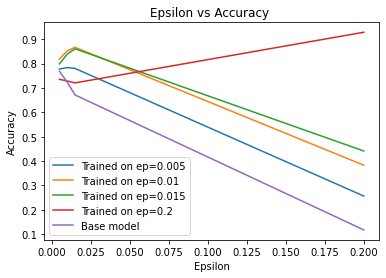

In [10]:
for epsilon in EPSILONS:
    print("Training model with epsilon: ", epsilon)
    transform = transforms.Compose([transforms.ToTensor()])
    fgsm_transform = transforms.Compose([ToTensor(),FGSMTransform(epsilon=epsilon)])

    # Download CIFAR10 dataset
    train_dataset1 = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
    train_dataset2 = CustomCIFAR(root='./data', train=True, transform=fgsm_transform)
    augmented_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2])
    train_loader= torch.utils.data.DataLoader(dataset=augmented_dataset, batch_size=64, shuffle=True)

    # Train the model
    model = CNN().to(device)
    # Define the loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(EPOCHS):
        for images, labels in train_loader:
            model.train()
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress.update(1)
    # #saving model
    name =  str(epsilon)[2:]
    torch.save(model.state_dict(), "./models/cnn_fgsm"+name+".pth")
    #testing model
    accuracies[epsilon], losses[epsilon] = compare_test("./models/cnn_fgsm"+name+".pth")

#plotting
for epsilon in EPSILONS:
    plt.plot(EPSILONS,accuracies[epsilon], "-",label="Trained on ep="+str(epsilon))
accuracies[0], losses[0] = compare_test("./models/cnn.pth")
plt.plot(EPSILONS,accuracies[0], "-",label="Base model")
plt.title("Epsilon vs Accuracy ")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Training model with epsilon:  0.005
Loss: 1.4558, Accuracy: 0.7464
Loss: 1.5646, Accuracy: 0.7313
Loss: 1.6968, Accuracy: 0.7132
Loss: 9.3842, Accuracy: 0.1703
	Accuracies: [0.7464172, 0.7312898, 0.7131767, 0.17028265]
	Losses: [1.4557567, 1.5646439, 1.6968427, 9.384199]
Training model with epsilon:  0.01
Loss: 1.4296, Accuracy: 0.7481
Loss: 1.4743, Accuracy: 0.7434
Loss: 1.5269, Accuracy: 0.7357
Loss: 8.9064, Accuracy: 0.2310
	Accuracies: [0.7481091, 0.7434315, 0.7356688, 0.23099124]
	Losses: [1.4296347, 1.4742998, 1.5269303, 8.906437]
Training model with epsilon:  0.015
Loss: 1.4447, Accuracy: 0.7503
Loss: 1.4439, Accuracy: 0.7489
Loss: 1.4552, Accuracy: 0.7468
Loss: 8.7992, Accuracy: 0.2148
	Accuracies: [0.75029856, 0.74890524, 0.74681526, 0.21476911]
	Losses: [1.4447073, 1.4438884, 1.4552497, 8.799245]
Training model with epsilon:  0.2
Loss: 1.2387, Accuracy: 0.7076
Loss: 1.2179, Accuracy: 0.7104
Loss: 1.1981, Accuracy: 0.7141
Loss: 1.0193, Accuracy: 0.7617
	Accuracies: [0.7076035,

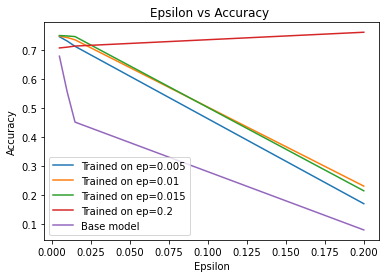

In [22]:
for epsilon in EPSILONS:
    print("Training model with epsilon: ", epsilon)
    transform = transforms.Compose([transforms.ToTensor()])
    fgsm_transform = transforms.Compose([ToTensor(),FGSMTransform(epsilon=epsilon)])

    # Download CIFAR10 dataset
    train_dataset1 = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
    train_dataset2 = CustomCIFAR(root='./data', train=True, transform=fgsm_transform)
    augmented_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2])
    train_loader= torch.utils.data.DataLoader(dataset=augmented_dataset, batch_size=64, shuffle=True)

    # Train the model
    model = CNN().to(device)
    # Define the loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(EPOCHS):
        for images, labels in train_loader:
            model.train()
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    # #saving model
    name =  str(epsilon)[2:]
    torch.save(model.state_dict(), "./models/cnn_fgsm"+name+".pth")
    #testing model
    accuracies[epsilon], losses[epsilon] = compare_test("./models/cnn_fgsm"+name+".pth")

#plotting
for epsilon in EPSILONS:
    plt.plot(EPSILONS,accuracies[epsilon], "-",label="Trained on ep="+str(epsilon))
accuracies[0], losses[0] = compare_test("./models/cnn.pth")
plt.plot(EPSILONS,accuracies[0], "-",label="Base model")
plt.title("Epsilon vs Accuracy ")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


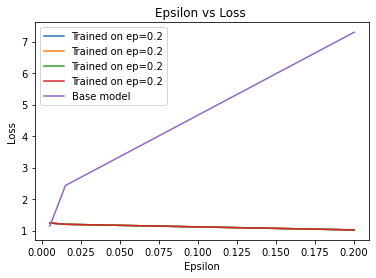

In [25]:
for e in EPSILONS:
    plt.plot(EPSILONS, losses[epsilon], "-",label="Trained on ep="+str(epsilon))
plt.plot(EPSILONS,losses[0], "-",label="Base model")
plt.title("Epsilon vs Loss ")
plt.xlabel("Epsilon")
plt.ylabel("Loss")
plt.legend()
plt.show()

# accuracies[0.005]= [0.7464172, 0.7312898, 0.7131767, 0.17028265]
# losses[0.005]= [1.4557567, 1.5646439, 1.6968427, 9.384199]
# accuracies[0.01]=[0.7481091, 0.7434315, 0.7356688, 0.23099124]
# losses[0.01]= [1.4296347, 1.4742998, 1.5269303, 8.906437]
# accuracies[0.015] =[0.75029856, 0.74890524, 0.74681526, 0.21476911]
# losses[0.015]= [1.4447073, 1.4438884, 1.4552497, 8.799245]
# accuracies[0.2]=[0.7076035, 0.71039015, 0.71407247, 0.7617436]
# losses[0.2]= [1.2386694, 1.2178786, 1.1981022, 1.0193268]
# accuracies[0]= [0.6790406, 0.55553347, 0.45173168, 0.07981688]
# losses[0]= [1.142326, 1.7771237, 2.4284132, 7.2948008]

Loss: 1.8618, Accuracy: 0.6948
Loss: 2.9535, Accuracy: 0.5868
Loss: 4.3798, Accuracy: 0.4648
Loss: 5.6308, Accuracy: 0.3797
Loss: 6.6548, Accuracy: 0.3097
	Accuracies: [0.69476515, 0.58678347, 0.4647691, 0.37967753, 0.30971336]
	Losses: [1.861755, 2.9534757, 4.37984, 5.630798, 6.6548038]
Loss: 1.5926, Accuracy: 0.7265
Loss: 2.0322, Accuracy: 0.6750
Loss: 2.7680, Accuracy: 0.5982
Loss: 3.7323, Accuracy: 0.5100
Loss: 4.7907, Accuracy: 0.4287
	Accuracies: [0.72651273, 0.6749602, 0.5982285, 0.50995225, 0.42874205]
	Losses: [1.5926452, 2.0321524, 2.7679734, 3.7323103, 4.790686]
Loss: 1.4852, Accuracy: 0.7418
Loss: 1.8432, Accuracy: 0.6979
Loss: 2.6149, Accuracy: 0.6186
Loss: 3.6606, Accuracy: 0.5159
Loss: 4.8075, Accuracy: 0.4248
	Accuracies: [0.7418392, 0.69785035, 0.6186306, 0.51592356, 0.42476115]
	Losses: [1.4851696, 1.8431809, 2.6149108, 3.6605575, 4.807515]
Loss: 1.1794, Accuracy: 0.7159
Loss: 1.1123, Accuracy: 0.7298
Loss: 1.0552, Accuracy: 0.7425
Loss: 1.0118, Accuracy: 0.7494
Loss:

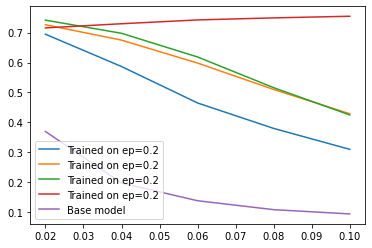

In [31]:
additional_epsilons = [0.02,0.04,0.06,0.08,0.1]
for e in EPSILONS:
    a, l = compare_test("./models/cnn_fgsm"+str(e)[2:]+".pth",additional_epsilons)
    plt.plot(additional_epsilons, a, "-",label="Trained on ep="+str(epsilon))
a, l = compare_test("./models/cnn.pth",additional_epsilons)
plt.plot(additional_epsilons,a, "-",label="Base model")
plt.legend()
plt.show()
    

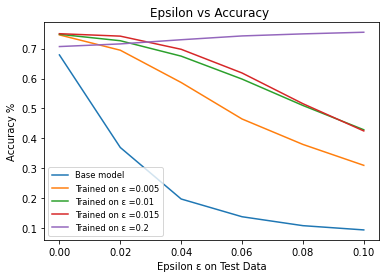

In [44]:
moo = [[0.746,0.69476515, 0.58678347, 0.4647691, 0.37967753, 0.30971336], 
       [ 0.748, 0.72651273, 0.6749602, 0.5982285, 0.50995225, 0.42874205],
       [0.75, 0.7418392, 0.69785035, 0.6186306, 0.51592356, 0.42476115],
       [0.707, 0.7158638, 0.72979695, 0.7425358, 0.7494029, 0.7548766]]
plt.plot([0]+additional_epsilons, [0.679]+a, "-",label="Base model")
for e, acc in zip(EPSILONS, moo):
    plt.plot([0]+additional_epsilons, acc, "-",label="Trained on \u03B5 ="+str(e))
plt.title("Epsilon vs Accuracy ")
plt.xlabel("Epsilon \u03B5 on Test Data")
plt.ylabel("Accuracy %")
plt.legend(loc="lower left", fontsize='small')
plt.show()